# Notebook to make Fig. 2

In [50]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
import imageio

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D

style.use('plotting.mplstyle')

import seaborn as sns
sns.color_palette('colorblind')

from helper_functions import *

### Load data 

Posterior samples

In [51]:
## TODO: finalize this with the real output dir
data_dir = '/Users/smiller/Documents/gw190521-timedomain-release/data_simonas_laptop/' 

tcutoffs = ['m50M', 'm40M', 'm37.5M', 'm35M', 'm32.5M', 'm30M', 'm27.5M', 'm25M', 'm22.5M', 'm20M', 
                'm17.5M', 'm15M', 'm12.5M', 'm10M', 'm7.5M', 'm5M', 'm2.5M', '0M', '2.5M', '5M', '7.5M', 
                '10M', '12.5M', '15M', '17.5M', '20M', '30M', '40M', '50M']

td_samples = load_posterior_samples(data_dir, tcutoffs)[0]

In [52]:
def get_plotting_dict(samples):
     
    # downsample to speed up plotting
    target_length = 7000
    mask = np.random.choice(len(samples['mtotal']), size=target_length, replace=False)
    
    # get mass samples
    mtot = samples['mtotal'][mask]
    q = samples['q'][mask]
    m1, m2 = m1m2_from_mtotq(mtot, q)
    
    # get chi_p
    chip = chi_precessing(m1, samples['chi1'][mask], samples['tilt1'][mask],
                                m2, samples['chi2'][mask], samples['tilt2'][mask])
    
    return {'chip':chip, 'mtot':mtot, 'q':q}

In [53]:
# Format samples into dict of what we want to plot

dict_to_plot = {}
for tc in np.concatenate([tcutoffs, ['prior'], ['full']]):
    
    # get samples
    if tc=='full'or tc=='prior':
        dict_to_plot[tc] = get_plotting_dict(td_samples[k])
    else: 
        for r in ['insp', 'rd']: 
            k = f'{r} {tc}'
            try: 
                samples = td_samples[k]
            except: 
                samples = td_samples['prior']
            dict_to_plot[k] = get_plotting_dict(samples)

Load in max likelihood and max posterior full reconstructions

In [54]:
maxP_maxL_full_data_fname = '050323_gw190521_full_NRSur7dq4_dec8_flow11_fref11_0M_TstartTend_maxP_maxL_wfs.npy'
maxP_maxL_full_dict = np.load(data_dir+maxP_maxL_full_data_fname,allow_pickle=True).item()

In [55]:
L1_maxP_strain_wh = maxP_maxL_full_dict['L1']['wh maxP']

dt_1M = 0.00127
t_0M_L1 = 1242442967.4250352

L1_times = (maxP_maxL_full_dict['L1']['times']-t_0M_L1)/dt_1M

### More things needed for fig

In [56]:
labels_dict = {'chip':r'$\chi_\mathrm{p}$', 'mtot':r'$M (1+z)$', 'q':r'$q$'}
bounds_dict = {'chip':(0,1), 'mtot':(200,500), 'q':(0.18,1)}
tc_lbls = {tc:tc.replace('m', '-') if tc[0]=='m' else tc for tc in tcutoffs}

In [57]:
# Cast strings to floats
tc_floats = {}
for tc_str in tcutoffs:
    if tc_str[0]=='m':
        tc_str_trimmed = tc_str[1:-1]
    else:
        tc_str_trimmed = tc_str[0:-1]     
    tc_float = -1*float(tc_str_trimmed) if tc_str[0]=='m' else float(tc_str_trimmed) 
    tc_floats[tc_str]=tc_float

Make kdes for full and prior runs

In [58]:
# grid on which to evaluate kdes
kde_dict = {}

for run in ['full', 'prior']: 
    
    # get samples
    samples = td_samples[run]
    mtot = samples['mtotal']
    q = samples['q']
    m1, m2 = m1m2_from_mtotq(mtot, q)
    chip = chi_precessing(m1, samples['chi1'], samples['tilt1'],
                          m2, samples['chi2'], samples['tilt2'])
    
    # make kdes
    chip_grid, chip_kde = reflected_kde(chip, *bounds_dict['chip'])
    q_grid, q_kde = reflected_kde(q, *bounds_dict['q'])
    mtot_grid, mtot_kde = reflected_kde(mtot, *bounds_dict['mtot'])
    
    kde_dict[run] = {
        'chip':{'kde':chip_kde, 'grid':chip_grid}, 
        'q':{'kde':q_kde, 'grid':q_grid}, 
        'mtot':{'kde':mtot_kde, 'grid':mtot_grid}, 
    }

### Make figure

In [67]:
def make_hist(keys, tc_to_plot, savename, bins = 30, labelsize = 15):
    
    ndim = len(keys)

    fig = plt.figure(figsize=(9,9))

    for i,key in enumerate(keys):

        # Plot the marginal 1D posterior(s) (i.e. top of a corner plot column)
        ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))

        bounds = bounds_dict[key]

        # Cycle through each tc and plot the posterior samples
        for r,tc in enumerate(tc_to_plot):

            posterior = dict_to_plot[f'rd {tc}'][key]

            ax.hist(posterior,bins=np.linspace(*bounds,bins), rasterized=True, density=True, zorder=0, 
                    histtype='step', color=f'C{r}',lw=2)

        # Add full posterior and prior
        ax.plot(kde_dict['full'][key]['grid'], kde_dict['full'][key]['kde'], color='k')
        if key=='q' or key=='mtot': 
            # uniform priors
            ax.axhline(1/(bounds_dict[key][1] - bounds_dict[key][0]), color='k', ls=':')
        else:
            ax.plot(kde_dict['prior'][key]['grid'], kde_dict['prior'][key]['kde'], color='k', ls=':')

        # Set axis bounds
        ax.set_xlim(*bounds)

        # Turn off tick
        ax.set_yticklabels([])
        ax.grid(axis='y')

        # If this is the last dimension add an x-axis label
        if i==ndim-1:
            ax.set_xlabel(labels_dict[key],fontsize=labelsize)

        # If not the last dimension, loop across other variables and fill in the rest of the column with 2D plots
        else:

            ax.set_xticklabels([])
            for j,k in enumerate(keys[i+1:]):

                # Make a 2D contour plot
                ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))

                # Axes bounds
                x_bounds = bounds_dict[key]
                y_bounds = bounds_dict[k]

                # Cycle through each run and plot the posterior samples
                for r,tc in enumerate(tc_to_plot):

                    posterior_x = dict_to_plot[f'rd {tc}'][key]
                    posterior_y = dict_to_plot[f'rd {tc}'][k]
                    posterior_df = pd.DataFrame({key:posterior_x, k:posterior_y})

                    # Use seaborn to make a kde plot
                    sns.kdeplot(data=posterior_df, 
                                x=key, y=k,
                                ax=ax, 
                                levels=[0.1, 0.5, 0.90],
                                fill=False,
                                zorder=2, 
                                color=f'C{int(r)}')

                # Set axis bounds
                ax.set_xlim(*x_bounds)
                ax.set_ylim(*y_bounds)
                ax.grid(True,dashes=(1,3))

                # If still in the first column, add a y-axis label
                if i==0:
                    ax.set_ylabel(labels_dict[k],fontsize=labelsize)
                else:
                    ax.set_ylabel('')
                    ax.set_yticklabels([])

                # If on the last row, add an x-axis label
                if j==ndim-i-2:
                    ax.set_xlabel(labels_dict[key],fontsize=labelsize)
                else:
                    ax.set_xlabel('')
                    ax.set_xticklabels([])

    # Legend
    legend_ax = fig.add_subplot(ndim,ndim,ndim-1)
    legend_ax.set_visible(False)
    handles = [Line2D([], [], color=f'C{r}',label=f'after $t = {tc_lbls[tc]}$') for r,tc in enumerate(tc_to_plot)]
    handles.append(Line2D([], [], color='k',label='full'))
    handles.append(Line2D([], [], color='k', ls=':', label='prior'))
    ax.legend(handles=handles, loc='lower center', fontsize=15, bbox_to_anchor=(0.5, 2))

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.savefig(f'{savename}.pdf',bbox_inches='tight',dpi=200)

    plt.show()

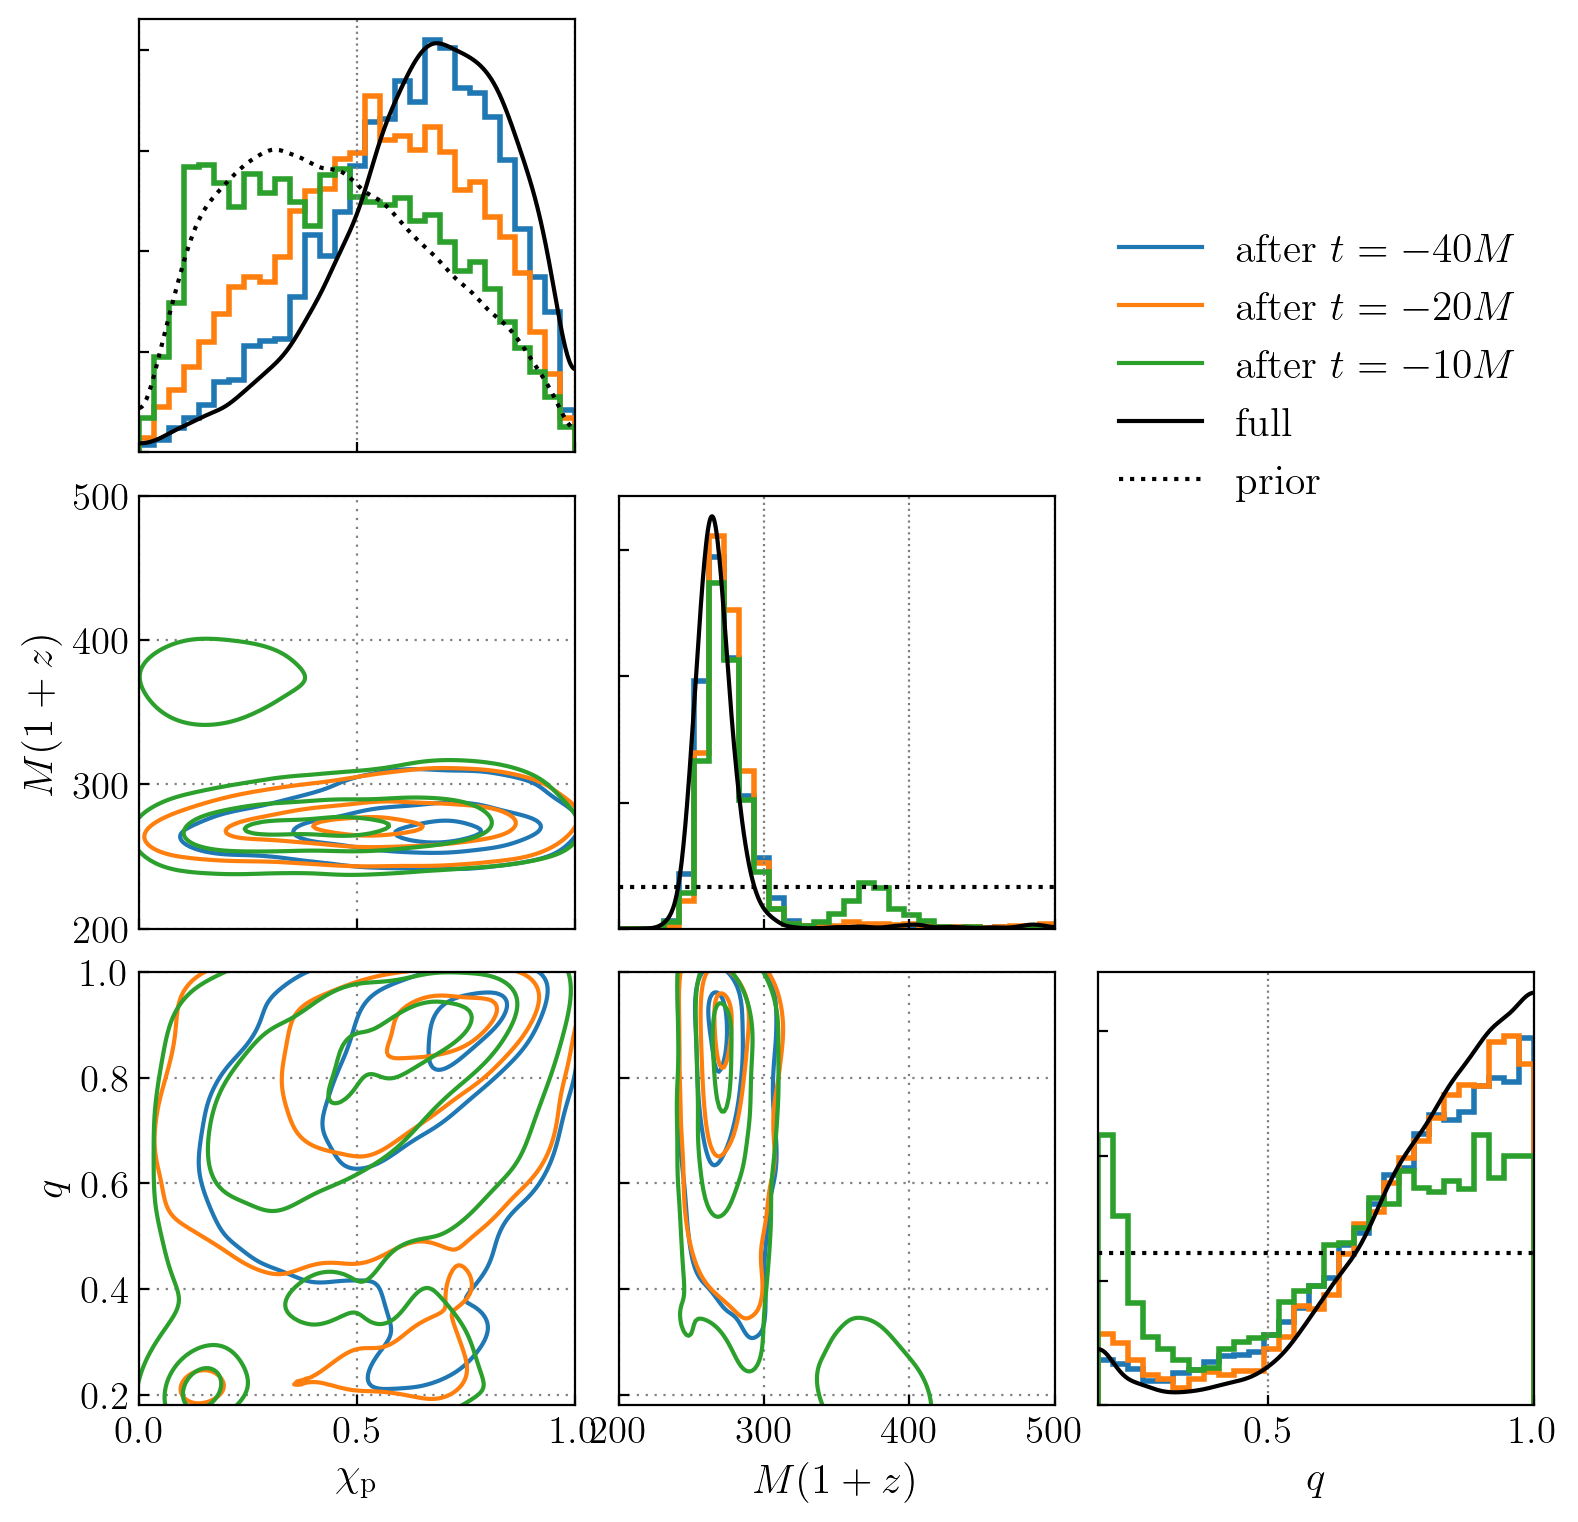

In [69]:
# fig 2a: for runs where chi_p posterior varies
tc_to_plot_chi_p = ['m40M', 'm20M', 'm10M'] 
make_hist(keys, tc_to_plot_chi_p, 'figure_02a')

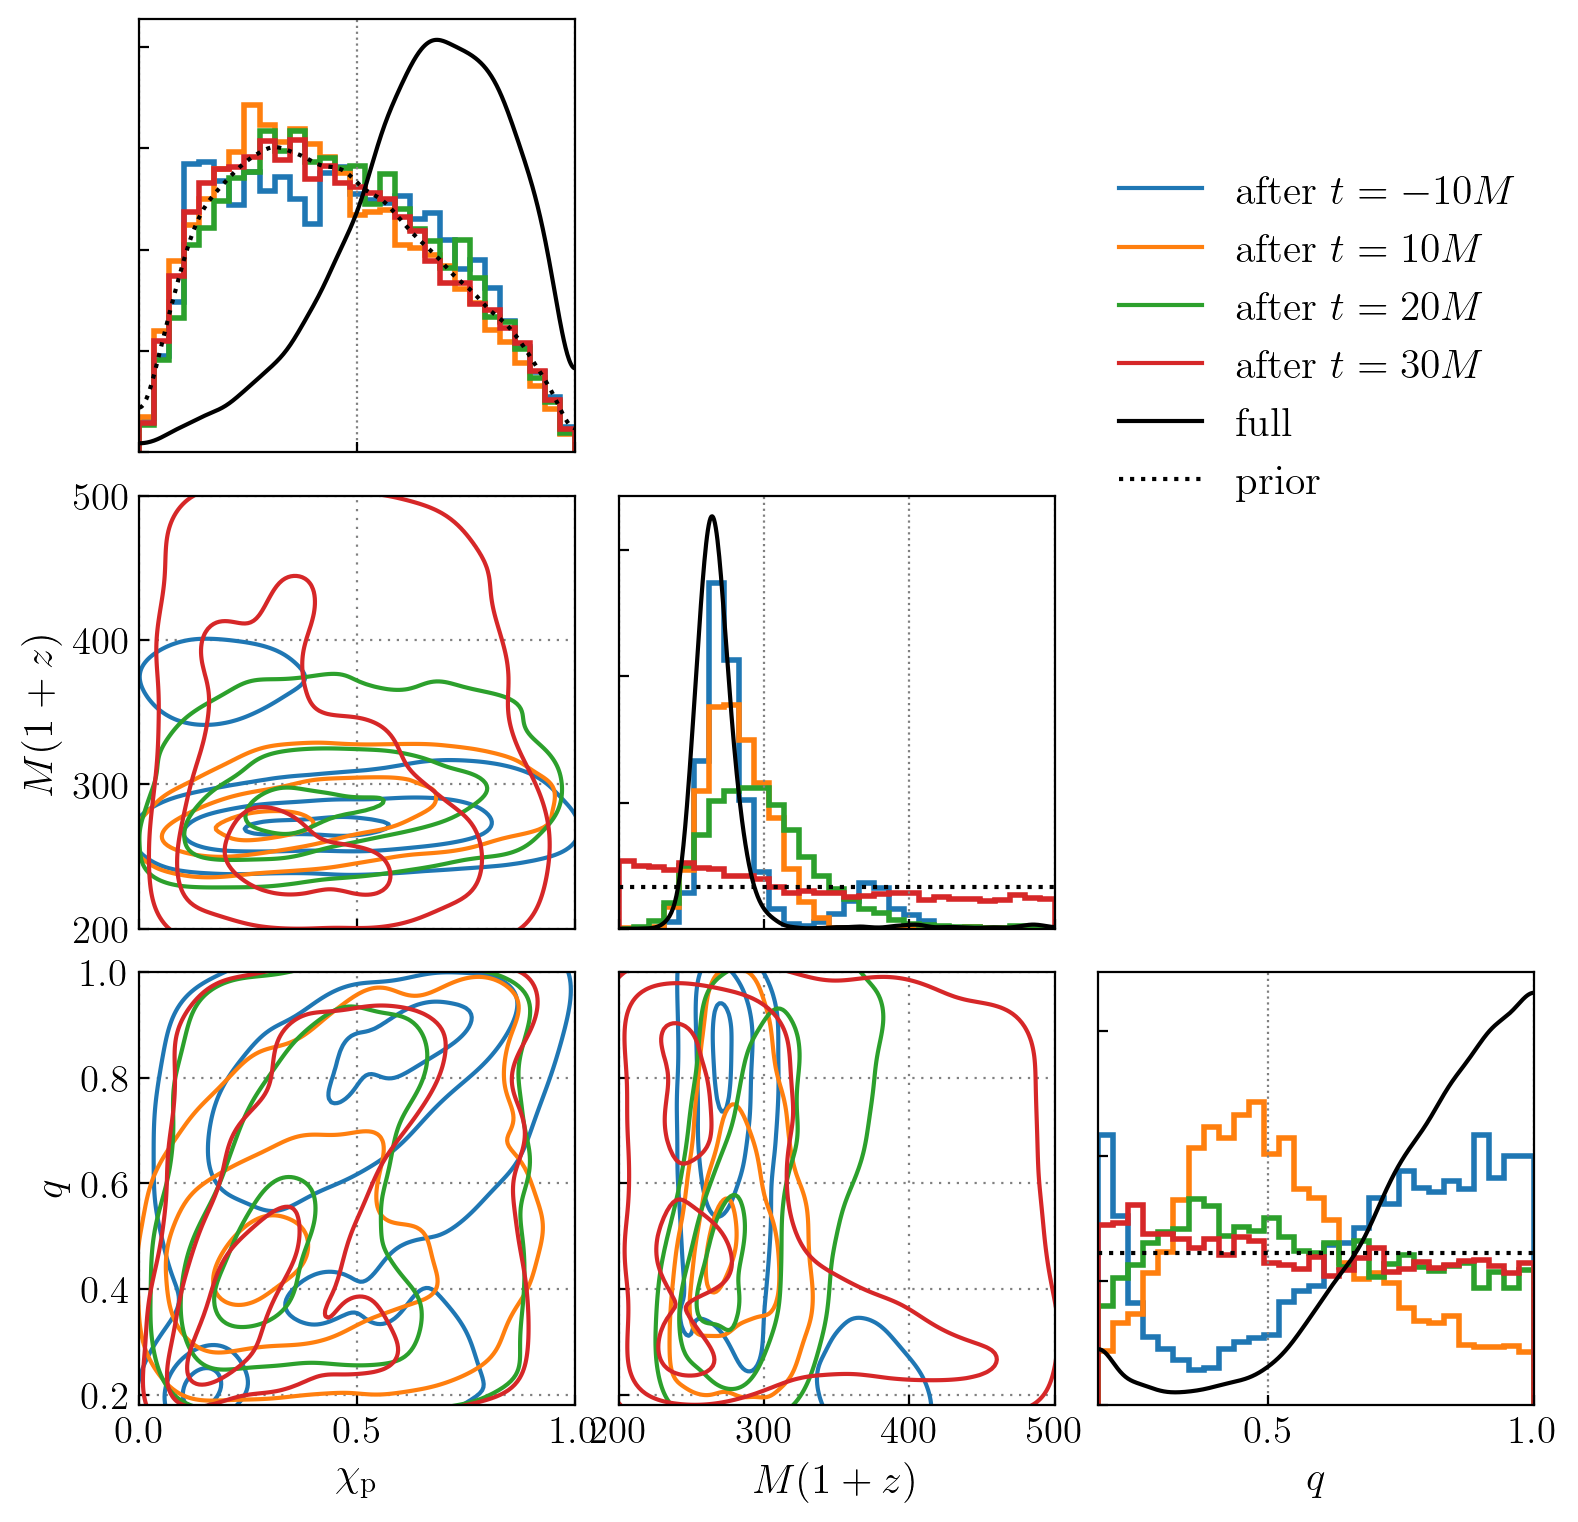

In [71]:
# fig 2b: for runs where mass posteriors vary
tc_to_plot_mass = ['m10M', '10M', '20M', '30M']
make_hist(keys, tc_to_plot_mass, 'figure_02b')

### Make gif version of figure including all time slices

In [60]:
keys = list(labels_dict)   
ndim = len(keys)
bins = 30
labelsize = 15

# Cycle through each tc
for r, tc in enumerate(tcutoffs):
    
    fig = plt.figure(figsize=(9,9))
    
    # Cycle through each parameter
    for i,key in enumerate(keys):

        # Plot the marginal 1D posterior(s) (i.e. top of a corner plot column)
        ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))

        bounds = bounds_dict[key]

        # Plot the posterior samples for before and after the cuts
        for n, x in enumerate(['insp', 'rd']):

            try:
                posterior = dict_to_plot[f'{x} {tc}'][key]
            except: 
                posterior = dict_to_plot['prior'][key]

            ax.hist(posterior,bins=np.linspace(*bounds,bins), rasterized=True, density=True, zorder=0, 
                    histtype='step', color=f'C{n}',lw=2)

        # Add full posterior and prior
        ax.plot(kde_dict['full'][key]['grid'], kde_dict['full'][key]['kde'], color='k')
        if key=='q' or key=='mtot': 
            # uniform priors
            ax.axhline(1/(bounds_dict[key][1] - bounds_dict[key][0]), color='k', ls=':')
        else:
            ax.plot(kde_dict['prior'][key]['grid'], kde_dict['prior'][key]['kde'], color='k', ls=':')

        # Set axis bounds
        ax.set_xlim(*bounds)

        # Turn off tick
        ax.set_yticklabels([])
        ax.grid(axis='y')

        # If this is the last dimension add an x-axis label
        if i==ndim-1:
            ax.set_xlabel(labels_dict[key],fontsize=labelsize)

        # If not the last dimension, loop across other variables and fill in the rest of the column with 2D plots
        else:

            ax.set_xticklabels([])
            for j,k in enumerate(keys[i+1:]):

                # Make a 2D contour plot
                ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))

                # Axes bounds
                x_bounds = bounds_dict[key]
                y_bounds = bounds_dict[k]

                # Plot the posterior samples for before and after the cut
                for n, x in enumerate(['insp', 'rd']):
                    try:
                        posterior_x = dict_to_plot[f'{x} {tc}'][key]
                    except: 
                        posterior_x = dict_to_plot['prior'][key]
                    try:
                        posterior_y = dict_to_plot[f'{x} {tc}'][k]
                    except: 
                        posterior_y = dict_to_plot['prior'][k]
                    posterior_df = pd.DataFrame({key:posterior_x, k:posterior_y})

                    # Use seaborn to make a kde plot
                    sns.kdeplot(data=posterior_df, 
                                x=key, y=k,
                                ax=ax, 
                                levels=[0.1, 0.5, 0.90],
                                fill=False,
                                zorder=2, 
                                color=f'C{int(n)}')

                # Set axis bounds
                ax.set_xlim(*x_bounds)
                ax.set_ylim(*y_bounds)
                ax.grid(True,dashes=(1,3))

                # If still in the first column, add a y-axis label
                if i==0:
                    ax.set_ylabel(labels_dict[k],fontsize=labelsize)
                else:
                    ax.set_ylabel('')
                    ax.set_yticklabels([])

                # If on the last row, add an x-axis label
                if j==ndim-i-2:
                    ax.set_xlabel(labels_dict[key],fontsize=labelsize)
                else:
                    ax.set_xlabel('')
                    ax.set_xticklabels([])

    # Legend
    legend_ax = fig.add_subplot(ndim,ndim,ndim-1)
    legend_ax.set_visible(False)
    handles = [Line2D([], [], color=f'C{r}',
                      label=f'{lbl} $t={tc_lbls[tc]}$') for r,lbl in enumerate(['before', 'after'])]
    handles.append(Line2D([], [], color='k',label='full'))
    handles.append(Line2D([], [], color='k', ls=':', label='prior'))
    ax.legend(handles=handles, loc='lower left', fontsize=13.5, bbox_to_anchor=(0.02, 1.85))
    
    # Plot waveform 
    wf_ax = fig.add_subplot(ndim,ndim,3)
    wf_ax.axis('off')
    mask = L1_times>tc_floats[tc]
    wf_ax.plot(L1_times, L1_maxP_strain_wh, color = 'C0')
    wf_ax.plot(L1_times[mask], L1_maxP_strain_wh[mask], color = 'C1')
    wf_ax.set_xlim(-55,70)
    wf_ax.set_ylim(-4.5, 4.5)

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.savefig(f'for_figure_02_gif/frame_{tc}.png',bbox_inches='tight',dpi=200)

    plt.close()

In [61]:
# Assemble into a gif
frames = []
for tc in tcutoffs:
    image = imageio.v2.imread(f'for_figure_02_gif/frame_{tc}.png')
    frames.append(image)
fps = 1.5
imageio.mimsave('figure_02.gif', frames, fps=fps)  